 -----------------------------------------------------------
# Reestimating Cogley and Sargent (2005) with the updated sample

* **Author:** Balint Szoke
* **Last update:** June, 2016

> Using the **updated sample** with the **priors of Cogley and Sargent (2005)** this notebook reestimates the stochastic volatility model (with time-varying coefficients) with `pymc` 

>> It requires `cogleysargent.py` which contains the following step methods:
 - `ForwardBackward`: $\hspace{6mm}\theta^T \hspace{2mm}\mid\hspace{2mm} Y^T, Q, R^T$
 - `W_Q`: $\hspace{30mm} Q^{-1}\hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T $
 - `Metropolis_LH`: $\hspace{9mm} H^T \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, \beta, \sigma $
 - `N_Beta`: $\hspace{28mm}\beta \hspace{2mm}\mid\hspace{2mm} Y^T, \theta^T, H^T$
 - `IG_Sigma`: $\hspace{22mm}\sigma^2 \hspace{2mm}\mid\hspace{2mm} Y^T, H^T$

>> and `cogleysargent_utils.py` 
 - `Genearate_prior` : class to estimate a SUR model on the training set in order to provide informative priors
 - `cs_model` : a function that creates a pymc model (see also the "replication notebook")
 
 -----------------------------------------------------------


### Model

We consider the following state-space model:

\begin{align}
y_t &= X_t\theta_t + \varepsilon_t \hspace{2cm}\text{where}\hspace{5mm} \varepsilon_t \sim \mathcal{N}(0,R_t) \\
\theta_{t} &= \theta_{t-1} + v_t \hspace{22mm}\text{where}\hspace{5mm} v_t \sim \mathcal{N}(0,Q) \\
\log(h_t) & = \log(h_{t-1}) + \eta_t \hspace{12mm}\text{where}\hspace{5mm} \eta_t \sim \mathcal{N}(0,\text{diag}(\sigma))
\end{align}

where $y_t$ is a vector of endogenous variables, $X_t$ includes constant plus lags of $y_t$ and $\theta_t$ is a vector of VAR parameters. The first equation is the measurement equation; the second is the state equation modeling the VAR coefficients as driftless random walks subject to reflecting barriers. The reflecting barrier is encoded in an indicator function $I(\theta^T)=\prod_{t=1}^T I(\theta_t)$, where $I(\theta_t)$ takes the value $1$ when $\theta_t$ implies roots of the associated VAR polynomial outside the unit circle and $0$ otherwise. This restriction truncates and renormalizes the random walk prior. 

$h_t$ is a vector of independent stochastic volatilities (same size as $y_t$) and 

\begin{align}
R_t = B^{-1}\text{diag}(h_t)(B^{-1})^T
\end{align}

**Notations:**
- $y_t$ and $\varepsilon_t$ are $K\times 1$-vectors for all $t=1,\dots,T$
- $x_t$ contains a constant plus $L$ lags of the endogenous variables, i.e. $x_t = [1, y_{t-1}^T, y_{t-2}^T, \dots, y_{t-L}^T]^T$ is an $M\times 1$ vector, where $M \equiv 1+LK$ and $X_t = I_K \otimes x^T_t$ is a $K\times KM$ matrix 
- $\theta_t$ and $v_t$ are $KM\times 1$ vectors
- $h_t$, $\eta_t$ and $\sigma$ are $K\times 1$-vectors, where $\sigma = [\sigma_1,\dots,\sigma_K]^T$
- $B$ is a $K\times K$ matrix 

$$B = \left[\begin{matrix} 1 & 0 & \dots & 0 \\ \beta_{2,1} & 1 & \dots & 0 \\  \dots & \dots & \dots & \dots \\ \beta_{K,1} & \beta_{K,2} & \dots & 1\end{matrix}\right] $$
- $J=\frac{K(K-1)}{2}$ is the total number of $\beta_{ij}$ included in $B$, i.e. $\beta=[\beta_{21}, \dots,\beta_{K(K-1)}]^T$ is a $J\times 1$ vector


### Priors

We assume that initial state $\theta_0$ and the hyperparameters are independent across blocks

$$f(\theta_0, h_0, Q^{-1}, \beta, \sigma) = f(\theta_0) f(h_0) f(Q^{-1}) f(\beta) f(\sigma) $$

and our priors are

- $\theta_0 \propto I(\theta_0)\mathcal{N}(\bar{\theta},\bar{P})$
- $Q^{-1} \sim \mathcal{W}(KM+1, \bar{Q})$ 
- $\sigma_i \sim \mathcal{IG}(\alpha_{i0},\beta_{i0})$ for $i=1,\dots, K$
- $h_{0,i} \sim \log\mathcal{N}(\bar{h}_i,\bar{P}_{h,i})$ for $i=1,\dots,K$
- $\beta \sim \mathcal{N}(\bar{\beta}, \bar{P}_{\beta})$

Notice that these along with the state equations already provide us with priors for $\theta^T$ and $h^T$.

### Defining the model in `pymc`

Therefore, we need to come up with values for the following parameters to define a pymc model:

$$\bar{\theta},\bar{P},\bar{Q},\bar{\beta},\bar{P}_{\beta},\{\alpha_{i0}\}_{i},\{\beta_{i0}\}_{i},\{\bar{h}_i\}_{i},\{\bar{P}_{h,i}\}_{i}$$

Given these parameters and the data we should be able to draw from the posterior distribution of any model of the above form. 

-------------------------------------------------------_

In [1]:
%matplotlib inline

# Standard packages:
import numpy as np
import scipy as sp
from scipy.linalg import inv
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb

# pymc and application specific packages
import pymc as pm
from cogleysargent import *
from cogleysargent_utils import *

### Load the updated sample and create the dataset passed to the prior generator

    Sample period: from 1948:Q2 to 2016:Q2
    Used time series:
        * dp : CPI for all urban consumers (seasonally adj), log diff between the third month of each quarter
        * y3 : yield on 3-month Treasury Bill, average of daily rates in the first month of each quarter
        * ur : civilian unemployment rate (seasonally adj), quarterly average of monthly rates
        ->  ur2 : logit of unemployment

In [2]:
data = pd.read_csv('../data/updated_sample.csv', index_col = 0)

# dependent variables of the VAR
y3 = np.expand_dims(data['y3'], 1)    # yield on 3-month Treasury bills
dp = np.expand_dims(data['dp'], 1)    # CPI for all urban consumers (seasonally-adj)
ur = np.expand_dims(data['ur'], 1)    # civilian unemployment rate (seasonally-adj)
ur2 = .01 * np.log(ur / (1 - ur))     # logit of unemployment

y = np.hstack((y3, ur2, dp))

Estimate the training sample to get priors

In [3]:
training = Generate_prior(y)

In [4]:
X, Y_obs, X_obs = training.create_YX()[3:]
theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar = training.informative_prior()

In [6]:
mcmc, Theta, LH, Q_inv, Sigma2, Betas, R = \
                cs_model(Y_obs, X_obs, X, theta_bar, b_bar, Pb_bar, a0, b0, lnh_bar, Ph_bar, P_bar, Q_bar)

In [7]:
NI = 10000
NB = 5000
NT = 10
mcmc.sample(iter = NI, burn = NB, thin = NT)

 [-----------------100%-----------------] 10000 of 10000 complete in 683.4 sec

In [8]:
print(np.mean(mcmc.trace('sigma2_1')[:]**.5))
print(np.mean(mcmc.trace('sigma2_2')[:]**.5))
print(np.mean(mcmc.trace('sigma2_3')[:]**.5))

0.331241133426
0.232924429904
0.0132466896914


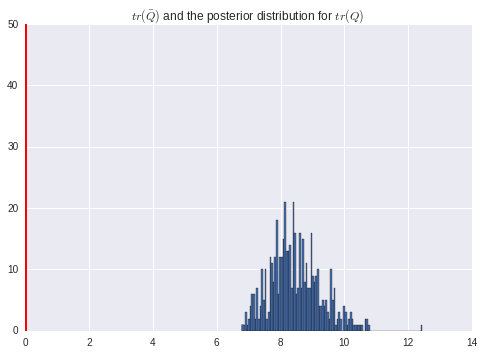

In [11]:
plt.hist([ np.trace(inv(mcmc.trace('Q_inv')[:][i])) for i in range(500)], bins=110)
plt.vlines(np.trace(Q_bar/22), 0, 50, color='r', lw=2)
#plt.axis([0,.25,0,500])
plt.title(r'$tr(\bar{Q})$ and the posterior distribution for $tr(Q)$ ')
plt.savefig('trQ_post.pdf')

In [21]:
T=training
cont_mean = np.empty((21,T+1))
cont_std = np.empty((21,T+1))
for j in range(21):
    cont_mean[j,:] = [np.mean(mcmc.trace('Theta_%d' % i)[:][:,j]) for i in range(T+1)]
    cont_std[j,:] = [np.std(mcmc.trace('Theta_%d' % i)[:][:,j]) for i in range(T+1)]

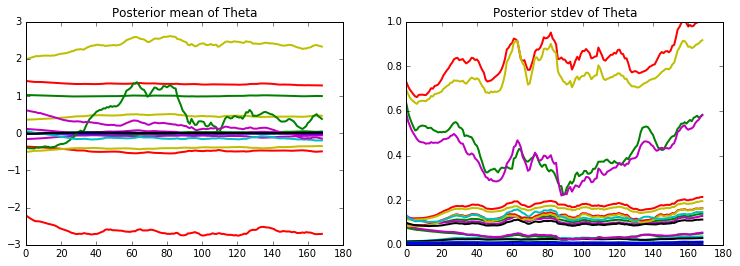

In [22]:
fig2, ax = plt.subplots(1,2, figsize = (12.5,4))
ax[0].plot(cont_mean.T, linewidth=2)
ax[0].set_title(r'Posterior mean of Theta')
ax[1].plot(cont_std.T, linewidth=2)
ax[1].set_ylim([0,1])
ax[1].set_title(r'Posterior stdev of Theta')
plt.savefig('theta.pdf')
plt.show()


In [24]:
H_mean = np.empty((5000,T+1,3,3))

for ss in range(5000):
    BI = inv(B_tril(mcmc.trace('betas')[:][ss,:]))
    for tt in range(T+1):
        SW = np.diag(np.exp(mcmc.trace('lnh_%d' % tt)[:][ss,:]))
        R = BI.dot(SW).dot(BI.T)
        H_mean[ss,tt,:,:] = R

In [25]:
HH_mean = np.mean(H_mean,0)
nomint = np.sqrt(HH_mean[:,0,0])
unemp = np.sqrt(HH_mean[:,1,1])
inflation = np.sqrt(HH_mean[:,2,2])

corr_nu = HH_mean[:,0,1]/( np.sqrt(HH_mean[:,0,0])*np.sqrt(HH_mean[:,1,1]))
corr_ni = HH_mean[:,0,2]/( np.sqrt(HH_mean[:,0,0])*np.sqrt(HH_mean[:,2,2]))
corr_iu = HH_mean[:,1,2]/( np.sqrt(HH_mean[:,1,1])*np.sqrt(HH_mean[:,2,2]))

ldR = np.empty((T+1,1))
for tt in range(T+1):
    ldR[tt,0] = np.log(np.linalg.det(HH_mean[tt,:,:]))

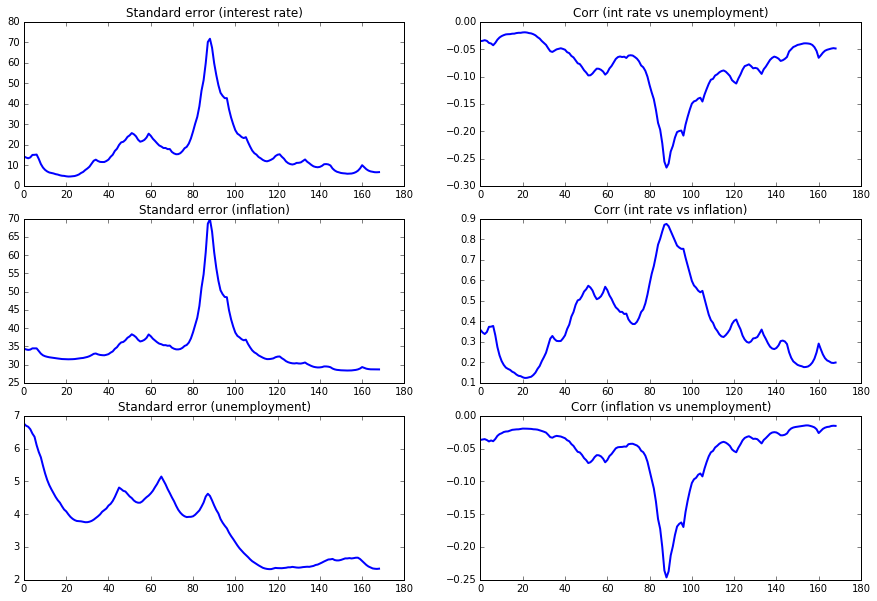

In [26]:
fig2, ax = plt.subplots(3,2, figsize=(15,10))
ax[0,0].plot(10000*nomint, linewidth=2)
ax[0,0].set_title(r'Standard error (interest rate)')
ax[1,0].plot(10000*inflation, linewidth=2)
ax[1,0].set_title(r'Standard error (inflation)')
ax[2,0].plot(10000*unemp, linewidth=2)
ax[2,0].set_title(r'Standard error (unemployment)')

ax[0,1].plot(corr_nu, linewidth=2)
ax[0,1].set_title(r'Corr (int rate vs unemployment)')
ax[1,1].plot(corr_ni, linewidth=2)
ax[1,1].set_title(r'Corr (int rate vs inflation)')
ax[2,1].plot(corr_iu, linewidth=2)
ax[2,1].set_title(r'Corr (inflation vs unemployment)')
plt.savefig('h.pdf')
plt.show()

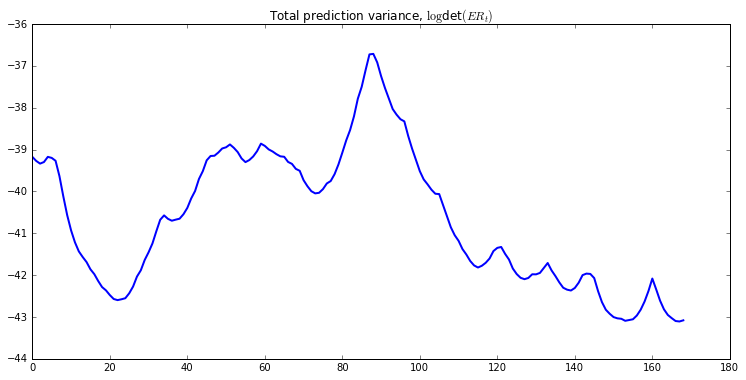

In [27]:
fig3, bx = plt.subplots(figsize = (12.5,6))
bx.plot(ldR, linewidth=2)
bx.set_title(r'Total prediction variance, $\log$det$(E R_t)$')
plt.savefig('PredVar.pdf')
plt.show()